In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.lossfunctions import *

In [3]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print (device)

cpu


In [19]:
start = time.time()
data_folder = 'data/demoplanner/version2'
train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 301.2297029495239 sec


In [20]:
print (train_data.data.shape)
print (test_data.data.shape)

print (train_data.data.device)
print (test_data.data.device)

torch.Size([129779, 2058])
torch.Size([6648, 2058])
cpu
cpu


In [ ]:
expts = [
#     ['DemoPl-V2-ComposedAutoEncoderNoMaxPool-MSE-', ComposedAutoEncoder, demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ComposedAutoEncoderNoMaxPool-SmoothL1-', ComposedAutoEncoder, demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
    ['DemoPl-V2-ComposedAutoEncoderWithMaxPool-MSE-', lambda: ComposedAutoEncoder(useMaxPool=True), demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-', lambda: ComposedAutoEncoder(useMaxPool=True), demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-DenseAutoEncoder3-MSE-', lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]), demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-DenseAutoEncoder3-SmoothL1-', lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]), demopl_v1_data_adapter, smooth_l1_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-VAE-VAELoss-', VAE, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
#     ['DemoPl-V2-ConvVAE-VAELoss-', ConvVae, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
]

In [ ]:
train_epochs = 2
for i in range(len(expts)):
    inputs = expts[i]
    net = inputs[1]()
    net = net.to(device)
    runner = ExptRunner(inputs[0], net, train_data, test_data, inputs[2], inputs[3], data_to_img_func=inputs[4])
    print ("Log folder for expt {}: {}".format(i, runner.log_folder))
    runner.train(train_epochs, shouldShowReconstruction=True)
    runner.test()

In [54]:
def test_samples(net, data, showfig):
    with torch.no_grad():
        criterion = nn.SmoothL1Loss()
        ip_batch = demopl_v1_data_adapter(data)
        op_batch, loss = smooth_l1_loss_adapter(net, ip_batch)
        rows = max(5, len(ip_batch))
        for i in range(rows):
            print('datapoint', str(i), 'test error', criterion(input=ip_batch[i], target=op_batch[i]))
            if showfig:
                plt.imshow(ip_batch[i].reshape(32,32), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
                plt.show()
                plt.imshow(op_batch[i].reshape(32,32), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
                plt.show()

def report_all_net_perf(test_data, rootdir='runs', showfig=False):
    for filename in glob.iglob(rootdir + '/**/*.pth', recursive=True):
        map_netname_net = {
            'ComposedAutoEncoderWithMaxPool': lambda: ComposedAutoEncoder(useMaxPool=True),
            'DenseAutoEncoder3': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]),
            'ComposedAutoEncoderNoMaxPool': lambda: ComposedAutoEncoder(useMaxPool=False),
#             'VAE': VAE,
#             'ConvVAE': ConvVae,
            '03-19-22-21-33-DemoPl-V2-DenseAutoEncoder3-MSE-': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 32]),
            '03-19-22-52-24-DemoPl-V2-DenseAutoEncoder3-SmoothL1-': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 32]),
        }
        folder = os.path.basename(os.path.dirname(filename))
        netname = folder.split('-')[7]
        if folder in map_netname_net.keys():
            net = map_netname_net[folder]()
        elif netname in map_netname_net.keys():
            net = map_netname_net[netname]()
        else:
            continue

        print ('Model File: {}'.format(filename))
        net.load_state_dict(torch.load(filename, map_location=device))
        test_samples(net, test_data, showfig)

In [55]:
report_all_net_perf(test_data.data[0:5, :].float()) # Performance comparison on first 5 samples of test data

Model File: runs/03-17/03-17-18-57-21-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-/autoenc.pth
datapoint 0 test error tensor(0.0013)
datapoint 1 test error tensor(0.0013)
datapoint 2 test error tensor(0.0010)
datapoint 3 test error tensor(0.0007)
datapoint 4 test error tensor(0.0010)
Model File: runs/03-17/03-17-19-22-49-DemoPl-V1-DenseAutoEncoder3-MSE-/autoenc.pth
datapoint 0 test error tensor(0.0062)
datapoint 1 test error tensor(0.0055)
datapoint 2 test error tensor(0.0043)
datapoint 3 test error tensor(0.0036)
datapoint 4 test error tensor(0.0025)
Model File: runs/03-17/03-17-18-26-46-DemoPl-V1-ComposedAutoEncoderWithMaxPool-MSE-/autoenc.pth
datapoint 0 test error tensor(0.0048)
datapoint 1 test error tensor(0.0037)
datapoint 2 test error tensor(0.0031)
datapoint 3 test error tensor(0.0025)
datapoint 4 test error tensor(0.0024)
Model File: runs/03-17/03-17-18-03-42-DemoPl-V1-ComposedAutoEncoderNoMaxPool-SmoothL1-/autoenc.pth
datapoint 0 test error tensor(0.0152)
datapoint 1 t

In [58]:
report_all_net_perf(train_data.data[0:5, :].float()) # Performance comparison on first 5 samples of training data

Model File: runs/03-17/03-17-18-57-21-DemoPl-V1-ComposedAutoEncoderWithMaxPool-SmoothL1-/autoenc.pth
datapoint 0 test error tensor(0.0025)
datapoint 1 test error tensor(0.0020)
datapoint 2 test error tensor(0.0020)
datapoint 3 test error tensor(0.0005)
datapoint 4 test error tensor(0.0018)
Model File: runs/03-17/03-17-19-22-49-DemoPl-V1-DenseAutoEncoder3-MSE-/autoenc.pth
datapoint 0 test error tensor(0.0040)
datapoint 1 test error tensor(0.0025)
datapoint 2 test error tensor(0.0015)
datapoint 3 test error tensor(0.0006)
datapoint 4 test error tensor(0.0056)
Model File: runs/03-17/03-17-18-26-46-DemoPl-V1-ComposedAutoEncoderWithMaxPool-MSE-/autoenc.pth
datapoint 0 test error tensor(0.0031)
datapoint 1 test error tensor(0.0022)
datapoint 2 test error tensor(0.0023)
datapoint 3 test error tensor(0.0012)
datapoint 4 test error tensor(0.0036)
Model File: runs/03-17/03-17-18-03-42-DemoPl-V1-ComposedAutoEncoderNoMaxPool-SmoothL1-/autoenc.pth
datapoint 0 test error tensor(0.0149)
datapoint 1 t

Model File: runs/03-19/03-19-17-40-38-DemoPl-V2-ComposedAutoEncoderWithMaxPool-MSE-/autoenc.pth
datapoint 0 test error tensor(0.0003)


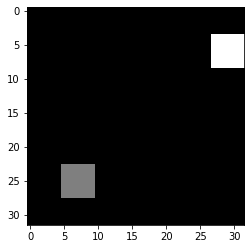

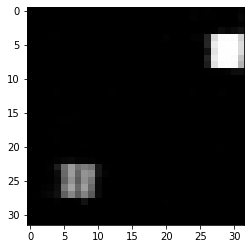

datapoint 1 test error tensor(0.0003)


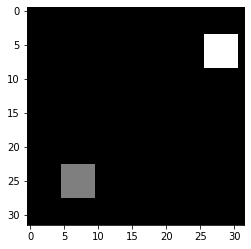

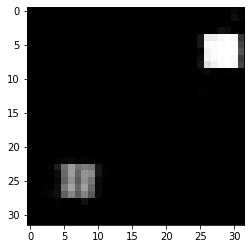

datapoint 2 test error tensor(0.0002)


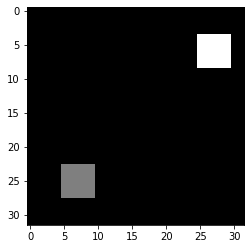

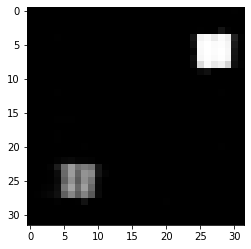

datapoint 3 test error tensor(0.0002)


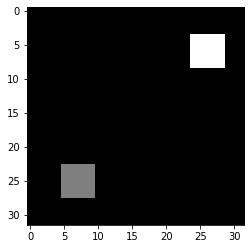

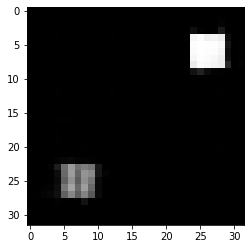

datapoint 4 test error tensor(0.0002)


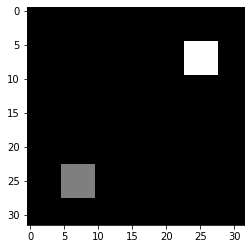

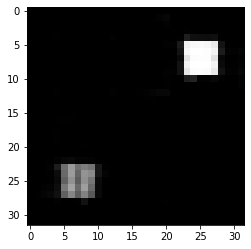

In [56]:
# Image reconstruction on test set with best network 1
report_all_net_perf(test_data.data[0:5, :].float(), 
                    rootdir='runs/03-19/03-19-17-40-38-DemoPl-V2-ComposedAutoEncoderWithMaxPool-MSE-', 
                    showfig=True)

Model File: runs/03-18/03-18-17-45-23-DemoPl-V2-ComposedAutoEncoderNoMaxPool-SmoothL1-/autoenc.pth
datapoint 0 test error tensor(0.0003)


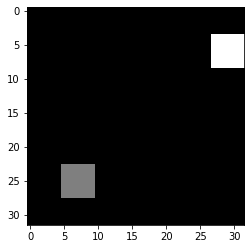

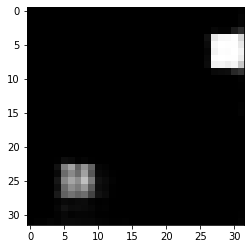

datapoint 1 test error tensor(0.0004)


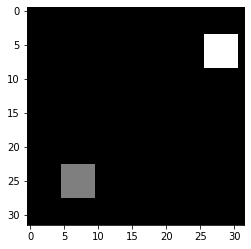

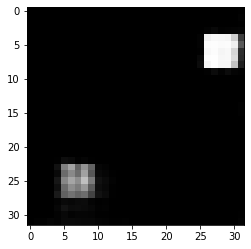

datapoint 2 test error tensor(0.0003)


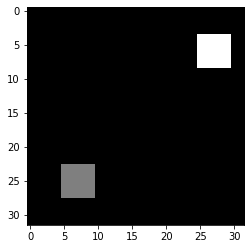

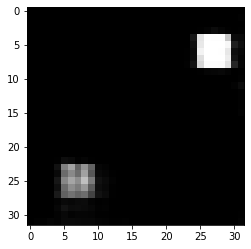

datapoint 3 test error tensor(0.0003)


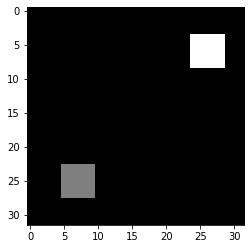

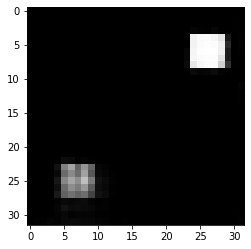

datapoint 4 test error tensor(0.0002)


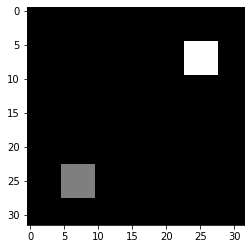

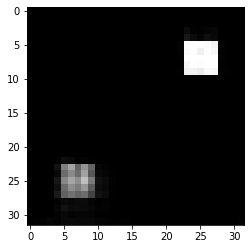

In [57]:
# Image reconstruction on test set with best network 2
report_all_net_perf(test_data.data[0:5, :].float(),
                    rootdir='runs/03-18/03-18-17-45-23-DemoPl-V2-ComposedAutoEncoderNoMaxPool-SmoothL1-', 
                    showfig=True)

In [ ]:
np.set_printoptions(**opt)